## CMSC 320 Final Project
## Analyzing the shift in NBA shot selection over the last decade
#### Arjun Jale, Rohith Reddi, Vedankt Talasila
12/12/2019

#### **Introduction**

Over the last decade, the use of analytics has become commonplace in a multitude of industries, with the goal being to use these analytics to improve day to day operations and make operations more efficient. Basketball and more specifically, the NBA, is no exception to this. Over the last decade, teams’ front offices have been hiring data analysts to support decision making in every aspect of basketball, from scouting prospects and undervalued players to helping planning practices and most importantly, to decide game plans and shot selection. 

Using shot data of every player on every team for the last decade, we will examine how analytics have resulted in a shift in shot selection in the NBA. To do this we will first look at shot scatter maps to see the general trend of shot attempts, and look to further analyze these changes and hopefully predict where the league might go. This will give us a good indication of how analytics have taken the NBA by storm this decade.


#### **Data Collection  | Part 1**

We are using Python 3 with the following packages:
- Pandas
- [NBA_API](https://github.com/swar/nba_api)
    - Used nba_api to get data on all players, shot data. This was the only way for us to get data as stats.nba.com would block out IP address if we pulled too much data.
- MatPlotLib
- NumPy
- StatsModels
- SciPi
- SKLearn


In [143]:
import pandas as pandas
import nba_api
import json2df
import matplotlib.pyplot as plt
import numpy as np
import plotly
from bs4 import BeautifulSoup as bs
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import json
from statsmodels.formula.api import ols
import requests
from jupyterthemes import jtplot

jtplot.style(theme='solarizedl')
# Set the number of rows and columns displayed by pandas in the Jupyter notebook
pandas.set_option('display.max_columns', 20)
pandas.set_option('display.max_rows', 300)

#### Preprocessing the Data

We first wanted to find a way to create a master dataframe that will contain all necessary data that we can then iterate over to pull more precise data. This was first done by pulling a list of [team id's](https://github.com/seemethere/nba_py/wiki/stats.nba.com-Endpoint-Documentation) and assigning them to team names. This ensured that when we  used the API, we would be able to get data for teams, as we needed to associate team ids. We chose to look at data from 2009-2018 as we would therefore not have to consider the Seattle Supersonics and the OKC Thunder(same franchise that moved cities) when using team ids;we also felt that this time line was a good base for which to determine the change in the modern NBA. 

In [2]:
# Gets the list of teams and their team id
team_id = pandas.read_csv("team_id.csv", sep=',')

# Create a dictionary of {TeamID: Team Name}
teamNameDict = {}
for index, row in team_id.iterrows():
    teamNameDict[str(row['TeamID'])] = str(row['Team name'])

We then used the API and the previous team id list to create a master roster with all the teams spanning all years to 2009 to 2019. This code took nearly 40 minutes to run. Therefore after running it once, we decided to provide you a downloaded copy of the API return.

```
# import nba_api commonteamroster endpoint
from nba_api.stats.endpoints import commonteamroster

# create empty dataframe for the master dataframe
master = pandas.DataFrame(columns = ['TeamID', 'SEASON', 'LeagueID',
              'PLAYER', 'NUM', 'POSITION', 'HEIGHT', 'WEIGHT', 'BIRTH_DATE', 'AGE', 'EXP', 'SCHOOL', 'PLAYER_ID'])

# go through and add data to the dataframe using nba_api
for index, row in team_id.iterrows():
    for year in range(2009,2019):
        yearString = str(year) + '-' + str(year-1999)
        roster = commonteamroster.CommonTeamRoster(team_id=str(row['TeamID']), season=str(yearString))
        master = master.append(roster.get_data_frames()[0], ignore_index=True)

master

# This code takes a very long time to run. Therefore, we have also provided a csv file that contains data we pulled from the api and saved.
```

In [3]:
# CSV file that results from the above code
master = pandas.read_csv("master.csv", sep=',')

# Add the team name to the dataframe
teamNames = []
for index, row in master.iterrows():
    teamNames.append(teamNameDict[str(row['TeamID'])])

master['Team Name'] = pandas.Series(teamNames, index=master.index)

# Remove unecessary columns
master = master.drop(columns=['LeagueID', 'School', 'Birth', 'Index'])
#master

Now we want to analyze shot data and in order to do that, we need to have shot data for every alternate year. We added each years data into a seperate dataframe.

```
roster1 = pandas.DataFrame(columns = ['PLAYER_ID', 'PLAYER_NAME', 'SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG'])
roster2 = pandas.DataFrame(columns = ['PLAYER_ID', 'PLAYER_NAME', 'SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG'])
roster3 = pandas.DataFrame(columns = ['PLAYER_ID', 'PLAYER_NAME', 'SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG'])
roster4 = pandas.DataFrame(columns = ['PLAYER_ID', 'PLAYER_NAME', 'SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG'])
roster5 = pandas.DataFrame(columns = ['PLAYER_ID', 'PLAYER_NAME', 'SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG'])

for index, row in master.iterrows(): 
    print (row["Season"], row["Player"], row["PlayerID"], row["Team Name"])
    if (row["Season"] == 2009):
            hold = shotchartdetail.ShotChartDetail(context_measure_simple='FGA',last_n_games='0',league_id='00',month = '0', opponent_team_id='0',period = '0',player_id=str(row['PlayerID']),season_type_all_star='Regular Season', team_id=row['TeamID'] ,season_nullable = str(2009) + '-' + str(int(2009)-1999)) 
        roster1 = roster1.append(hold.get_data_frames()[0])
    
for index, row in master.iterrows(): 
    print (row["Season"], row["Player"], row["PlayerID"], row["Team Name"])
    if (row["Season"] == 2011):
            hold = shotchartdetail.ShotChartDetail(context_measure_simple='FGA',last_n_games='0',league_id='00',month = '0', opponent_team_id='0',period='0',player_id=str(row['PlayerID']),season_type_all_star='Regular Season', team_id=row['TeamID'],season_nullable=str(2011) + '-' + str(int(2011)-1999)) 
        roster2 = roster2.append(hold.get_data_frames()[0])

for index, row in master.iterrows(): 
    print (row["Season"], row["Player"], row["PlayerID"], row["Team Name"])
    if (row["Season"] == 2013):
            hold = shotchartdetail.ShotChartDetail(context_measure_simple='FGA',last_n_games='0',league_id='00',month ='0', opponent_team_id='0',period='0',player_id=str(row['PlayerID']),season_type_all_star='Regular Season', team_id=row['TeamID'],season_nullable=str(2013) + '-' + str(int(2013)-1999)) 
        roster3 = roster3.append(hold.get_data_frames()[0])
        
for index, row in master.iterrows(): 
    print (row["Season"], row["Player"], row["PlayerID"], row["Team Name"])
    if (row["Season"] == 2015):
            hold = shotchartdetail.ShotChartDetail(context_measure_simple='FGA',last_n_games='0',league_id='00', month ='0', opponent_team_id='0', period='0', player_id=str(row['PlayerID']),season_type_all_star='Regular Season',          team_id=row['TeamID'],season_nullable=str(2015) + '-' + str(int(2015)-1999)) 
        roster4 = roster4.append(hold.get_data_frames()[0])
        
for index, row in master.iterrows(): 
    print (row["Season"], row["Player"], row["PlayerID"], row["Team Name"])
    if (row["Season"] == 2017):
            hold = shotchartdetail.ShotChartDetail(context_measure_simple='FGA',last_n_games='0',league_id='00', month='0', opponent_team_id='0', period='0', player_id = str(row['PlayerID']), season_type_all_star='Regular Season',              team_id= row['TeamID'], season_nullable=str(2017) + '-' + str(int(2017)-1999)) 
        roster5 = roster5.append(hold.get_data_frames()[0])
```

#### Reading the Data

Due to the volume of the data we have provided you with an offline copy.

In [4]:
#This code is used to export the data to a csv file
#export_csv = roster1.to_csv (r'2009Shots.csv', index = None, header=True)
#export_csv = roster2.to_csv (r'2011Shots.csv', index = None, header=True)
#export_csv = roster3.to_csv (r'2013Shots.csv', index = None, header=True)
#export_csv = roster4.to_csv (r'2015Shots.csv', index = None, header=True)
#export_csv = roster5.to_csv (r'2017Shots.csv', index = None, header=True)

#Import the offline data
shot09 = pandas.read_csv("2009Shots.csv", sep=',')
shot11 = pandas.read_csv("2011Shots.csv", sep=',')
shot13 = pandas.read_csv("2013Shots.csv", sep=',')
shot15 = pandas.read_csv("2015Shots.csv", sep=',')
shot17 = pandas.read_csv("2017Shots.csv", sep=',')

The code below was provided to us by Savvas Tjortjoglou, who created this open source NBA court shape array. We use this to draw the court on our plots. [Link](https://github.com/savvastj/nbashots/blob/master/nbashots/charts.py)

In [22]:
import matplotlib.patches as mpatches

def draw_court(ax=None, color='gray', lw=1, outer_lines=False):
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    hoop = plt.Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = plt.Rectangle((-30, -12.5), 60, 0, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = plt.Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = plt.Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = mpatches.Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = mpatches.Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = mpatches.Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the right side 3pt lines, it's 14ft long before it arcs
    corner_three_a = plt.Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    # Create the right side 3pt lines, it's 14ft long before it arcs
    corner_three_b = plt.Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    three_arc = mpatches.Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = mpatches.Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = mpatches.Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = plt.Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

#### Exploratory Analysis & Data Visualization

The following cells analyze the shots taken by each player each alternate year from 2009 to 2017. Due to the extremely high volume of shots taken by players we decided to take a random sample of each year so that we would have 30,000 data points per year. 

We then created a scatter map of the makes and misses taken by the players on the court with red indicating a miss and blue indicating a make. We can then see where on the court players are preferring to take over the years. 

After, we wanted to see if the distance of the shots taken behind the 3 point line is increasing. This will tell us if players are sticking to the 3 point line or if they are shooting from a further point.

Then we wanted to make a pie chart of the distance that players are taking these shots so we can clearly see what types of shots are getting more popular over the years. 

#### Visualizing Scatter Maps

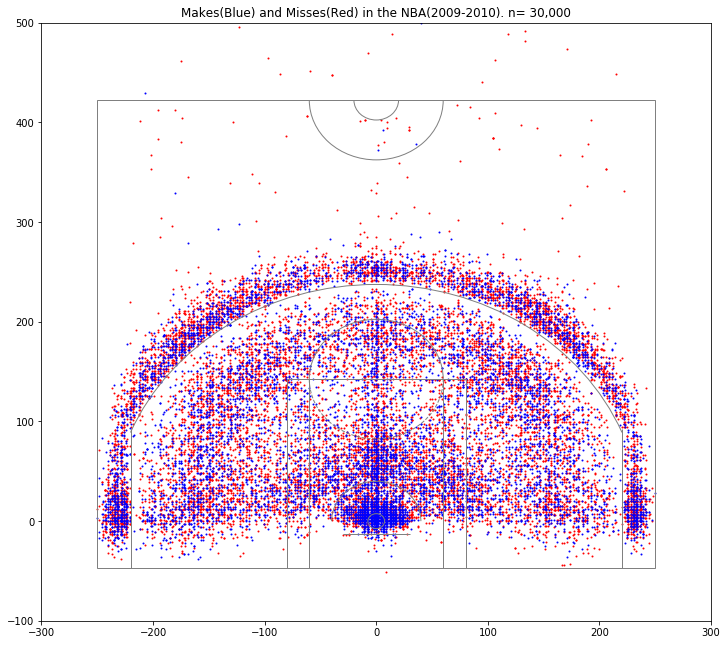

In [43]:
sample1 = shot09.sample(frac=0.1581277672, replace=True, random_state=1)
plt.figure(figsize=(12,11))
plt.scatter(sample1[sample1['SHOT_MADE_FLAG'] == 0]['LOC_X'], sample1[sample1['SHOT_MADE_FLAG'] == 0]['LOC_Y'], c = 'red', s=1)
plt.scatter(sample1[sample1['SHOT_MADE_FLAG'] == 1]['LOC_X'], sample1[sample1['SHOT_MADE_FLAG'] == 1]['LOC_Y'], c = 'blue', s=1)
plt.xlim(-300,300)
draw_court(outer_lines=True)
plt.title("Makes(Blue) and Misses(Red) in the NBA(2009-2010). n= 30,000")
plt.ylim(-100,500)
plt.show()

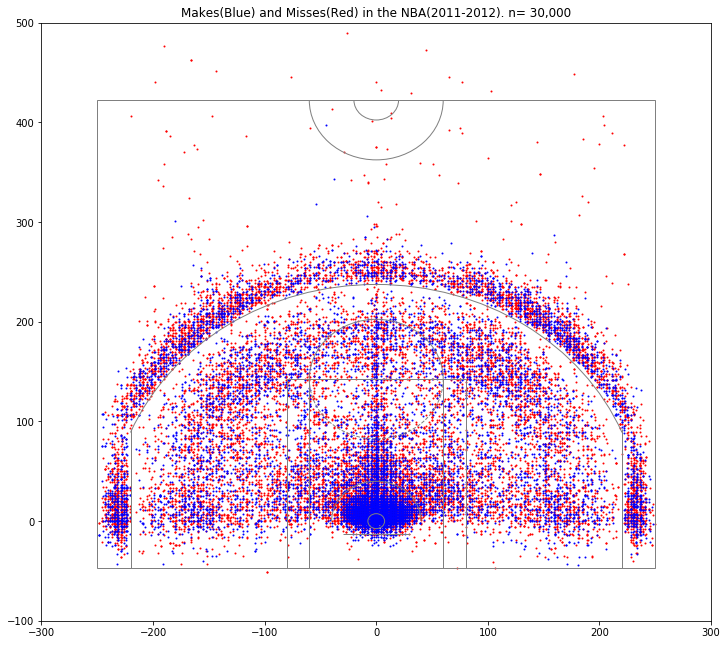

In [28]:
sample2 = shot11.sample(frac=0.1951346429, replace=True, random_state=1)
plt.figure(figsize=(12,11))
plt.scatter(sample2[sample2['SHOT_MADE_FLAG'] == 0]['LOC_X'], sample2[sample2['SHOT_MADE_FLAG'] == 0]['LOC_Y'], c = 'red', s=1)
plt.scatter(sample2[sample2['SHOT_MADE_FLAG'] == 1]['LOC_X'], sample2[sample2['SHOT_MADE_FLAG'] == 1]['LOC_Y'], c = 'blue', s=1)
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.title("Makes(Blue) and Misses(Red) in the NBA(2011-2012). n= 30,000")
plt.ylim(-100,500)
plt.show()

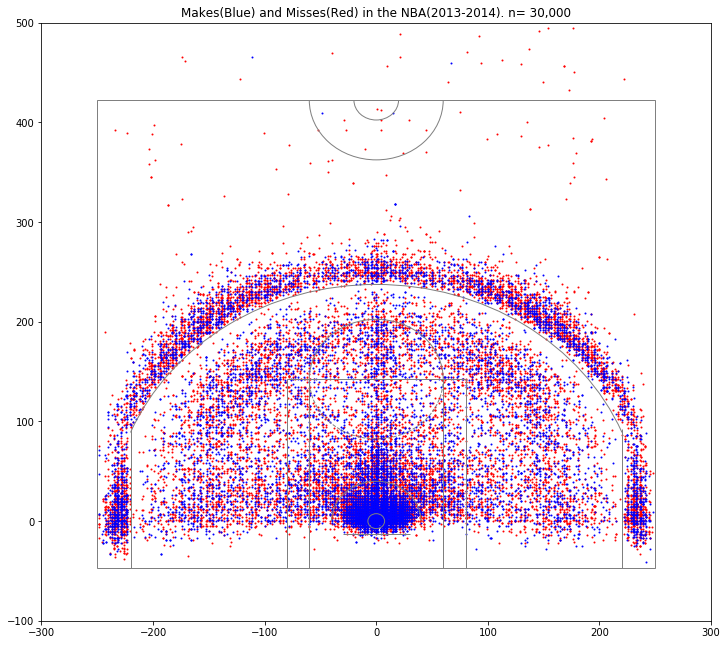

In [29]:
sample3 = shot13.sample(frac=0.1569201, replace=True, random_state=1)
plt.figure(figsize=(12,11))
plt.scatter(sample3[sample3['SHOT_MADE_FLAG'] == 0]['LOC_X'], sample3[sample3['SHOT_MADE_FLAG'] == 0]['LOC_Y'], c = 'red', s=1)
plt.scatter(sample3[sample3['SHOT_MADE_FLAG'] == 1]['LOC_X'], sample3[sample3['SHOT_MADE_FLAG'] == 1]['LOC_Y'], c = 'blue', s=1)
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.title("Makes(Blue) and Misses(Red) in the NBA(2013-2014). n= 30,000")
plt.ylim(-100,500)
plt.show()

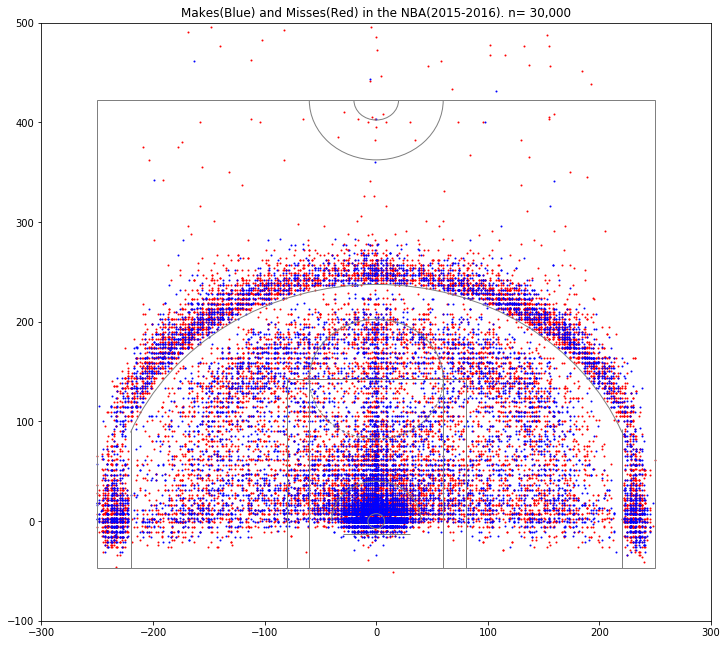

In [30]:
sample4 = shot15.sample(frac=0.1515381118, replace=True, random_state=1)
plt.figure(figsize=(12,11))
plt.scatter(sample4[sample4['SHOT_MADE_FLAG'] == 0]['LOC_X'], sample4[sample4['SHOT_MADE_FLAG'] == 0]['LOC_Y'], c = 'red', s=1)
plt.scatter(sample4[sample4['SHOT_MADE_FLAG'] == 1]['LOC_X'], sample4[sample4['SHOT_MADE_FLAG'] == 1]['LOC_Y'], c = 'blue', s=1)
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.title("Makes(Blue) and Misses(Red) in the NBA(2015-2016). n= 30,000")
plt.ylim(-100,500)
plt.show()

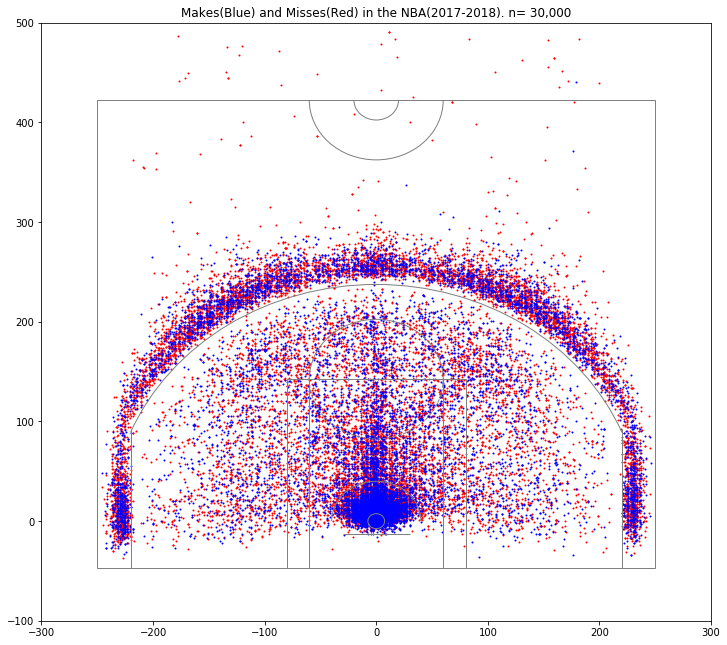

In [31]:
sample5 = shot17.sample(frac=0.1508750754, replace=True, random_state=1)
plt.figure(figsize=(12,11))
plt.scatter(sample5[sample5['SHOT_MADE_FLAG'] == 0]['LOC_X'], sample5[sample5['SHOT_MADE_FLAG'] == 0]['LOC_Y'], c = 'red', s=1)
plt.scatter(sample5[sample5['SHOT_MADE_FLAG'] == 1]['LOC_X'], sample5[sample5['SHOT_MADE_FLAG'] == 1]['LOC_Y'], c = 'blue', s=1)
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.title("Makes(Blue) and Misses(Red) in the NBA(2017-2018). n= 30,000")
plt.ylim(-100,500)
plt.show()

#### Analysis of Scatter Maps

In the 2009-2010 season, we can see there is a pretty even distribution of shots around the court, from shots inside the restricted area, the midrange, and the 3 point line. When we fast forward to the 2017-2018 season, we see a drastic change in the areas where the most shots are taken. It seems the shots from the midrange have significantly decreased and have gravitated to either inside the restricted area or beyond the 3 point line, the areas that saw the largest significant increase in the shots attempted. When we look at the years in between, we see that there is a general increase in the shots attempted in these areas. However the change was quite small until we see it get emphasized in the 2017-2018 season. 
	
When looking a bit closer at this massive change between the 2015-2016 season and the 2017-2018 season, we see the majority of the decrease in mid-range shots came underneath the foul line, followed by a significant increase in the volume of corner 3s taken. 

#### Visualization of Histograms

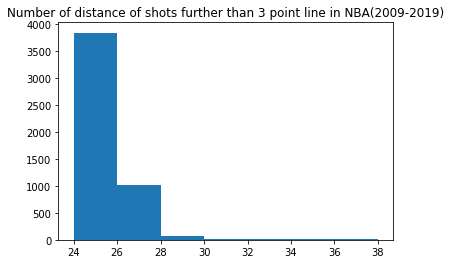

6.908358509566968% of shots are greater than 26 feet away from the basket
11.69052488070893% of 3 pointers are greater than 26 feet away from the basket


In [32]:
chart1 = {}
array1 = []

for index, row in sample1.iterrows(): 
    if row['SHOT_ZONE_RANGE'] in chart1:
        chart1[row['SHOT_ZONE_RANGE']] = chart1.get(row['SHOT_ZONE_RANGE']) + 1
    else:
        chart1[row['SHOT_ZONE_RANGE']] = 1
        
    if row['SHOT_DISTANCE'] >= 24 and row['SHOT_DISTANCE'] <= 38:
        array1.append(row['SHOT_DISTANCE'])

plt.hist(array1, bins=7)
plt.title("Number of distance of shots further than 3 point line in NBA(2009-2019)")
plt.show()

count = 0
all = 0
for element in array1:
    if element > 26:
        count = count + 1
    if element > 24:
        all = all + 1

print(str((count/len(array1))*100) + "% of shots are greater than 26 feet away from the basket")
print(str((count/all)*100) + "% of 3 pointers are greater than 26 feet away from the basket")

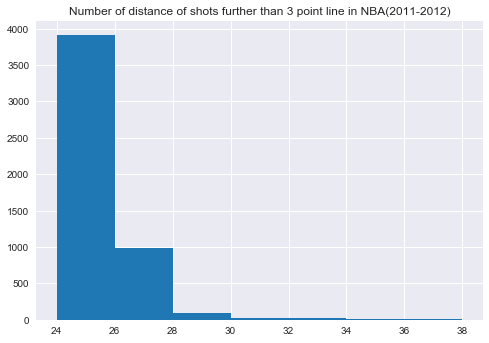

8.033240997229916% of shots are greater than 26 feet away from the basket
13.753387533875339% of 3 pointers are greater than 26 feet away from the basket


In [134]:
chart2 = {}
array2 = []

for index, row in sample2.iterrows(): 
    if row['SHOT_ZONE_RANGE'] in chart2:
        chart2[row['SHOT_ZONE_RANGE']] = chart2.get(row['SHOT_ZONE_RANGE']) + 1
    else:
        chart2[row['SHOT_ZONE_RANGE']] = 1
        
    if row['SHOT_DISTANCE'] >= 24 and row['SHOT_DISTANCE'] <= 38:
        array2.append(row['SHOT_DISTANCE'])

plt.hist(array2, bins=7)
plt.title("Number of distance of shots further than 3 point line in NBA(2011-2012)")
plt.show()

count = 0
all = 0
for element in array2:
    if element > 26:
        count = count + 1
    if element > 24:
        all = all + 1

print(str((count/len(array2))*100) + "% of shots are greater than 26 feet away from the basket")
print(str((count/all)*100) + "% of 3 pointers are greater than 26 feet away from the basket")

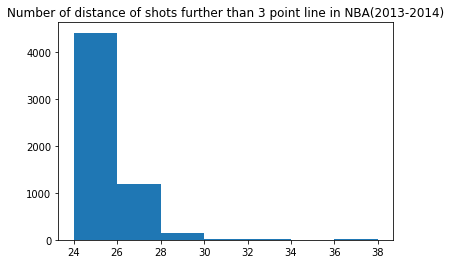

7.971641016773301% of shots are greater than 26 feet away from the basket
12.540805223068553% of 3 pointers are greater than 26 feet away from the basket


In [34]:
chart3 = {}
array3 = []

for index, row in sample3.iterrows(): 
    if row['SHOT_ZONE_RANGE'] in chart3:
        chart3[row['SHOT_ZONE_RANGE']] = chart3.get(row['SHOT_ZONE_RANGE']) + 1
    else:
        chart3[row['SHOT_ZONE_RANGE']] = 1
        
    if row['SHOT_DISTANCE'] >= 24 and row['SHOT_DISTANCE'] <= 38:
        array3.append(row['SHOT_DISTANCE'])

plt.hist(array3, bins=7)
plt.title("Number of distance of shots further than 3 point line in NBA(2013-2014)")
plt.show()

count = 0
all = 0
for element in array3:
    if element > 26:
        count = count + 1
    if element > 24:
        all = all + 1

print(str((count/len(array3))*100) + "% of shots are greater than 26 feet away from the basket")
print(str((count/all)*100) + "% of 3 pointers are greater than 26 feet away from the basket")

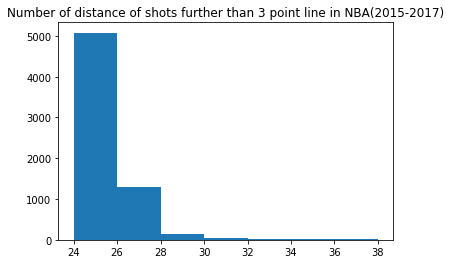

7.847908745247148% of shots are greater than 26 feet away from the basket
13.614775725593667% of 3 pointers are greater than 26 feet away from the basket


In [35]:
chart4 = {}
array4 = []

for index, row in sample4.iterrows(): 
    if row['SHOT_ZONE_RANGE'] in chart4:
        chart4[row['SHOT_ZONE_RANGE']] = chart4.get(row['SHOT_ZONE_RANGE']) + 1
    else:
        chart4[row['SHOT_ZONE_RANGE']] = 1
        
    if row['SHOT_DISTANCE'] >= 24 and row['SHOT_DISTANCE'] <= 38:
        array4.append(row['SHOT_DISTANCE'])

plt.hist(array4, bins=7)
plt.title("Number of distance of shots further than 3 point line in NBA(2015-2017)")
plt.show()

count = 0
all = 0
for element in array4:
    if element > 26:
        count = count + 1
    if element > 24:
        all = all + 1

print(str((count/len(array4))*100) + "% of shots are greater than 26 feet away from the basket")
print(str((count/all)*100) + "% of 3 pointers are greater than 26 feet away from the basket")

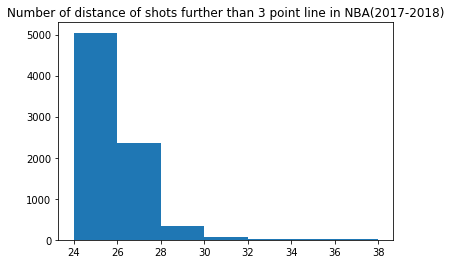

13.628250892401836% of shots are greater than 26 feet away from the basket
17.579345502384477% of 3 pointers are greater than 26 feet away from the basket


In [36]:
chart5 = {}
array5 = []

for index, row in sample5.iterrows(): 
    if row['SHOT_ZONE_RANGE'] in chart5:
        chart5[row['SHOT_ZONE_RANGE']] = chart5.get(row['SHOT_ZONE_RANGE']) + 1
    else:
        chart5[row['SHOT_ZONE_RANGE']] = 1
        
    if row['SHOT_DISTANCE'] >= 24 and row['SHOT_DISTANCE'] <= 38:
        array5.append(row['SHOT_DISTANCE'])

plt.hist(array5, bins=7)
plt.title("Number of distance of shots further than 3 point line in NBA(2017-2018)")
plt.show()

count = 0
all = 0
for element in array5:
    if element > 26:
        count = count + 1
    if element > 24:
        all = all + 1

print(str((count/len(array5))*100) + "% of shots are greater than 26 feet away from the basket")
print(str((count/all)*100) + "% of 3 pointers are greater than 26 feet away from the basket")

#### Analysis of Histograms

To look at the number of “deep 3s taken”, we look at the of number of 3s taken from 26-28 feet. In the 2009-2010 season, we see that there were about 1000 shots taken from this range. There seemed to be a gradual increase up until the 2015-2016 season, where there was about 1200 shots taken from this range. 

We again see a massive jump when comparing the 2015-2016 season to the 2017-2018 season. The number of 26-28 foot jump shots taken skyrocketed up to 2200 shots. This suggests teams are attempting deeper 3 pt shots more often.

We can get a better look at the increase in “deep 3s” taken by looking at the percentage of 3 point shots taken from 26 feet and beyond. We make the cut off at at shots taken beyond 38 feet, because these are usually half court shots taken at the end of quarters and games and have a very low percentage. 

We see that in the 2009-2010 season, about 11.6 percent of 3s taken were taken above 26 feet. Although this percentage increases up to 13.8 percent in the 2011-2012 season, it actually decreases to 12.5 percent in the 2013-2014 season, and slightly rebounds back up 13.6 percent in the 2015-2016 season. Once again there is a significant increase from the 2015-2016 season to the 2017-2018 season, where the percentage of 3s taken above 26 feet was 17.6 percent.

When comparing the number of any shots vs the number of shots taken above 26 feet, this disparity becomes even larger. In the 2015-2016 season, about 7.8 percent of all shots are greater than 26 feet away from the basket, where as in the 2017-2018 season, about 13.6 percent of all shots are greater than 26 feet away from the basket.


#### Visualization of Pie Charts

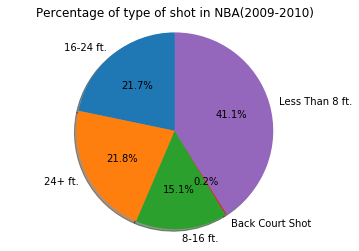

In [37]:
data = sorted(chart1.keys())       
        
labels = []
values = []

for key in data:
    labels.append(key)
    values.append(chart1.get(key))
    
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Percentage of type of shot in NBA(2009-2010)")
plt.show()

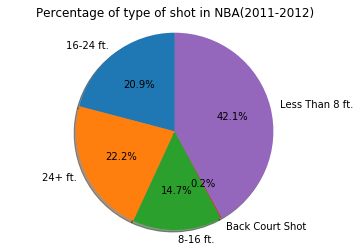

In [38]:
data = sorted(chart2.keys())       
        
labels = []
values = []

for key in data:
    labels.append(key)
    values.append(chart2.get(key))
    
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Percentage of type of shot in NBA(2011-2012)")
plt.show()

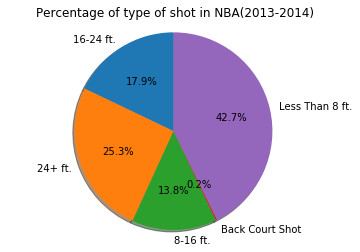

In [39]:
data = sorted(chart3.keys())       
        
labels = []
values = []

for key in data:
    labels.append(key)
    values.append(chart3.get(key))
    
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Percentage of type of shot in NBA(2013-2014)")
plt.show()

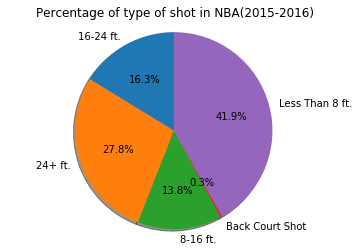

In [40]:
data = sorted(chart4.keys())       
        
labels = []
values = []

for key in data:
    labels.append(key)
    values.append(chart4.get(key))
    
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Percentage of type of shot in NBA(2015-2016)")
plt.show()

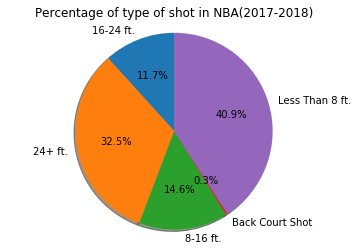

In [41]:
data = sorted(chart5.keys())       
        
labels = []
values = []

for key in data:
    labels.append(key)
    values.append(chart5.get(key))
    
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Percentage of type of shot in NBA(2017-2018)")
plt.show()

In [132]:
colIndices = ['Year', 'Zone', 'Percent Taken']
totalList = []
sampleList = [sample1, sample2, sample3, sample4, sample5]
count = 0
for sample in sampleList:
    percentVal = 1.00 / sample.shape[0]
    percentDict = {}
    year = str(2009 + count*2)
    for index, row in sample.iterrows():
        zoneVal = (row['SHOT_ZONE_BASIC'])
        if zoneVal in percentDict.keys():
            percentDict[zoneVal] += percentVal
        elif zoneVal != 'Backcourt':
            percentDict[zoneVal] = percentVal
    for zone, percent in percentDict.items():
        totalList.append([year, zone, percent*100])
    count += 1
totalZoneDf = pandas.DataFrame(totalList, columns=colIndices)
print (totalZoneDf)

    Year                   Zone  Percent Taken
0   2009        Restricted Area      33.230000
1   2009              Mid-Range      31.553333
2   2009          Left Corner 3       3.160000
3   2009      Above the Break 3      15.916667
4   2009         Right Corner 3       2.823333
5   2009  In The Paint (Non-RA)      13.140000
6   2011              Mid-Range      30.330000
7   2011         Right Corner 3       2.916667
8   2011      Above the Break 3      16.193333
9   2011        Restricted Area      32.370000
10  2011  In The Paint (Non-RA)      14.926667
11  2011          Left Corner 3       3.123333
12  2013              Mid-Range      26.686667
13  2013         Right Corner 3       3.090000
14  2013        Restricted Area      32.626667
15  2013  In The Paint (Non-RA)      15.173333
16  2013      Above the Break 3      18.596667
17  2013          Left Corner 3       3.616667
18  2015      Above the Break 3      20.806667
19  2015              Mid-Range      24.910000
20  2015     

In [139]:
import warnings
warnings.filterwarnings("ignore")

newColIndices = ['Year', 'Zone', 'Percent Taken', 'Normalized Percent Taken']
temp = totalZoneDf[totalZoneDf['Year'] == '2009']
normalTakenZoneDf = pandas.DataFrame(columns = newColIndices)
zoneList = temp['Zone'].values.tolist()
for zone in zoneList:
    temp1 = totalZoneDf[totalZoneDf['Zone'] == zone]
    temp1Copy = temp1
    meanPercent = temp1['Percent Taken'].mean()
    for index, row in temp1.iterrows():
        toAppendList = [[row['Year'], row['Zone'], row['Percent Taken'],(row['Percent Taken']/meanPercent)]]
        toAppendDf = pandas.DataFrame(toAppendList, columns=newColIndices)
        normalTakenZoneDf = normalTakenZoneDf.append(toAppendDf)
normalTakenZoneDf

,Year,Zone,Percent Taken,Normalized Percent Taken
0,2009,Restricted Area,33.230000,1.017286
0,2011,Restricted Area,32.370000,0.990959
0,2013,Restricted Area,32.626667,0.998816
0,2015,Restricted Area,32.643333,0.999327
0,2017,Restricted Area,32.456667,0.993612
0,2009,Mid-Range,31.553333,1.192191
0,2011,Mid-Range,30.330000,1.145970
0,2013,Mid-Range,26.686667,1.008312
0,2015,Mid-Range,24.910000,0.941184
0,2017,Mid-Range,18.853333,0.712343


#### Pie Chart Analysis

This pie chart gives us a much clearer visual of the distances of the shots taken by the league. For reference, shots less than 8 ft away from the basket are hook shots and layups (which are basically push shots and not considered a jump shot). Shots between 8-24 feet includes the midrange and shots from 24+ feet are 3 point shots. Once again, we are going to more or less ignore back court shots as they are almost always a desperation shot at the buzzer and not very significant.

In the 2009-2010 season, we see that the lowest percentage of shots were taken from 24+ feet and 16-24 feet, with their percentages almost equal. As the seasons go by, we gradually see less shots being taken from 16-24 feet and more shots taken from 24+ feet, with shots taken from less than 16 feet remain relatively the same. Once again the biggest percentage change in these two areas came between the 2015-2016 season and the 2017-2018 season. The last pie chart shows us that the league in 2017-2018 had 32.5% of shots taken from 24+ feet, a 10.7 percent increase from the 2009-2010 season, and 11.7% of shots taken from 16-24 feet, a 10 percent decrease from the 2009-2010 season. This largely suggests that the midrange shot has been significantly devalued over the last decade. To further analyze and confirm these claims, we looked to first take a look at the percentage of shots taken in every basic zone. To see the change over time, it is best to normalize this percentage, and doing so allows us to confirm our claims made above(as seen in normalTakenZoneDf). 


#### Hypothesis Testing and Machine Learning

We will be conducting a two sample z test. We are choosing a two sample z test because we know the population standard deviation, we can assume normality due to the Central Limit Theorem and we want to test the difference between two sample averages.

In this case we will be testing the average distance of a 3 in 2009 and in 2017. If we can find that the average distance of a 3 in 2009 - the average distance of a 3 in 2017 is less than 0, then we can conclude that the three point line needs to be moved further away. 

##### Hypothesis
H0: u1 - u2 = 0 
(average distance of 3 point shot in 2009 - average distance of 3 point shot in 2017 = 0)

HA: u1 - u2 != 0 
(average distance of 3 point shot in 2009 - average distance of 3 point shot in 2017 != 0)

Where u1 = the average distance of a three point shot in the year 2009 and u2 = the average distance of a three point shot in the year 2017

##### Assumptions
Assume H0 is true
Sampling distribution will be approximately normal

In [45]:
from scipy import stats
from statsmodels.stats import weightstats as stests

ztest ,pval = stests.ztest(array1, array2, value=0,alternative='two-sided')

print("P-Value: " + str(float(pval)))
if pval<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

P-Value: 0.2399709677552111
accept null hypothesis


#### Hypothesis Test Conclusion

Based on the sample data, there is insufficient evidence to conclude that we need to move the 3 point line further away from the basket based on a .05 level of significance. This means that the difference in averages between the distance of a 3 point shot in 2009 and the distance of a 3 point shot in 2017 is not significant enough to move the 3 point line back.

#### ANOVA Test

A ANOVA test is used to determine the true mean of more than 2 populations. We are testing whether there are two years which have a significant difference in the true average distance of 3 point shots.

###### Hypothesis
H0: The average distances of three point shots is the same year after year
HA: There are at least two years where the average distance of a three point shot is significantly different. 

##### Assumptions
The population is normal due to the central limit theorem, the population standard deviation is known and samples were selected independently. 

In [95]:
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols

summary1 = pandas.DataFrame(columns = ['Year', 'Distance'], dtype=float)
years = []
for element in array1:
    years.append('2009')
summary1['Year'] = years
summary1['Distance'] = array1   
    
summary2 = pandas.DataFrame(columns = ['Year', 'Distance'], dtype=float)
years = []
for element in array2:
    years.append('2011')
summary2['Year'] = years
summary2['Distance'] = array2
    
summary3 = pandas.DataFrame(columns = ['Year', 'Distance'], dtype=float)
years = []
for element in array3:
    years.append('2013')
summary3['Year'] = years
summary3['Distance'] = array3

summary4 = pandas.DataFrame(columns = ['Year', 'Distance'], dtype=float)
years = []
for element in array4:
    years.append('2015')
summary4['Year'] = years
summary4['Distance'] = array4
    
summary5 = pandas.DataFrame(columns = ['Year', 'Distance'], dtype=float)
years = []
for element in array5:
    years.append('2017')
summary5['Year'] = years
summary5['Distance'] = array5
    
all = pandas.DataFrame(columns = ['Year', 'Distance'], dtype=float)
all = all.append(summary1)
all = all.append(summary2)
all = all.append(summary3)
all = all.append(summary4)
all = all.append(summary5)
rp.summary_cont(all['Distance'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Distance,30221.0,25.092353,1.31016,0.007537,25.077581,25.107125


In [91]:
rp.summary_cont(all['Distance'].groupby(all['Year']))

,N,Mean,SD,SE,95% Conf.,Interval
Year,,,,,,
2009,4965,24.961531,1.266761,0.017978,24.926291,24.996771
2011,5054,24.992481,1.366799,0.019226,24.954795,25.030168
2013,5783,25.040463,1.275079,0.016767,25.007597,25.073330
2015,6575,24.961369,1.258388,0.015519,24.930949,24.991789
2017,7844,25.387557,1.322132,0.014928,25.358296,25.416818


In [93]:
s = stats.f_oneway(all['Distance'][all['Year'] == '2009'], 
               all['Distance'][all['Year'] == '2011'],
               all['Distance'][all['Year'] == '2013'],
               all['Distance'][all['Year'] == '2015'],
               all['Distance'][all['Year'] == '2017'])
s

F_onewayResult(statistic=140.5206179137043, pvalue=3.2287397886970275e-119)

In [92]:
results = ols('Distance ~ C(Year)', data=all).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Distance   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     140.5
Date:                Sun, 15 Dec 2019   Prob (F-statistic):          3.23e-119
Time:                        20:25:08   Log-Likelihood:                -50767.
No. Observations:               30221   AIC:                         1.015e+05
Df Residuals:                   30216   BIC:                         1.016e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          24.9615      0.018   1354.815      0.000      24.925      24.998
C(Year)[T.2011]     0.0310      0.026      1.193      0.233      -0.020       0.082
C(Year)[T.2013]     0.0789      0.025      3.143      0.002       0.030       0.128
C(Year)[T.2015]    -0.0002      0.024     -0.007      0.995      -0.048       0.048
C(Year)[T.2017]     0.4260      0.024     18.095      0.000       0.380       0.472
==============================================================================
Omnibus:                    22041.273   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           571442.165
Skew:                           3.243   Prob(JB):                         0.00
Kurtosis:                      23.292   Cond. No.                         6.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Anova Test Analysis

As we can see from both the scipy.stats and statsmodels tests, the p value indicates that the years have an average 3 point shot distance that is not significant enough to be different. This is inline with our two sample z test as well.

#### Conclusion
As avid basketball fans who have been watching the NBA since 2011, it is clear by watching games that the three point shot has become more and more valued, and the mid-range shot has become less and less valued. To see if the eye test held true, we gathered shot data from every player on every team for the last decade to see if we could confirm any trends we had been seeing over the years and more specifically the last few. After looking at the shot charts and other helpful visualization tools across the years, we were able to confirm the general upwards trend in 3pt shots taken and the general downwards trend in the number of mid-range shots taken. 
	While there was a general trend from the beginning of the decade to the end, we also see from the data that the biggest changes actually came between the 2015-2016 season and the 2017-2018 season. This also matches our eye test as this is when the rise of Stephen Curry and the Warriors began. Stephen Curry is often credited as a player who changed the game, with his ability to consistently hit the deep 3 from anywhere on the floor. However, Rockets general manager Darel Morey saw this and took this one set further. The MIT graduate found that the most efficient shots in basketball are the 3 pointer and the layup using analytics and expected values. With this, he was also able to find that the midrange shot is wildly inefficient. Because of this, The Rockets by far shoot the most 3s in the league and by far shoot the least mid-range shots in the league. If you want to learn more about Darryl Morey's analytics based decision making, you can check out this article: https://vinuselvaratnam.org/2018/06/22/daryl-morey-and-the-power-of-data-analytics-in-basketball/, which describes his decision making in other facets of the game, such as scouting and drafting. 
	As we can see from the big changes in shot location from the 2015-2016 season to the 2017-2018 season, Daryl Morrey’s influence has clearly rubbed off on the rest of the NBA. 
	However, not only have 3 point shots increased, but the average range of these 3 point shot has also increased significantly, especially in the last three or so years. Because of this, many are questioning if the 3 point line should be moved back to accommodate for the leagues increasing range. After running a 2 sample z test and an ANOVA test, we were able to conclude that there is not a significant enough difference in the average range of 3-pointers taken in the 2009-2010 season compared to the 2017-2018 season to warrant this change. However, if the same trends continue at the same rate it has been for the last three or so years, this question will not go away.
	To conclude, after analyzing over 2 million datapoints, we were able to confirm our eye test of the increasing rate of 3 point shots and the range they are taken at, along with the decreasing rate of the mid-range shot. As ardent NBA fans we would love to see someone else's project with this data set, and have have provided the [data](https://www.dropbox.com/sh/ru6n1u460pzbc5n/AAAO87DWSODXKs6NUNJtZWXEa?dl=0) here with all the csv's used in the making of this tutorial. See if you can do your own analysis and make conclusions from this nba shot data(we would love to check it out so link us if you do! =]). Hope you enjoyed this tutorial for our UMD CMSC 320 Final Project! 

